Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [x] Get your model's test accuracy. (One time, at the end.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [x] Make exploratory visualizations.
- [x] Do one-hot encoding.
- [x] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [x] Get and plot your coefficients.
- [x] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

## Data Exploration

In [7]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
df.shape

(421, 59)

In [9]:
df.isnull().sum().sort_values(ascending = True)

Burrito             0
Tortilla            0
Great               0
Date                0
Synergy             2
Uniformity          2
Hunger              3
Wrap                3
Fillings            3
Cost                7
Meat:filling        9
Meat               14
Temp               20
Salsa              25
Length            138
Circum            140
Volume            140
Beef              242
Cheese            262
Pico              263
Guac              267
Fries             294
Sour cream        329
Yelp              334
Google            334
Pork              370
Sauce             383
Rice              385
Beans             386
Unreliable        388
Chips             395
Density (g/mL)    399
Mass (g)          399
Chicken           400
Shrimp            400
Onion             404
Cilantro          406
Avocado           408
Lettuce           410
Cabbage           413
Bell peper        414
Salsa.1           414
NonSD             414
Pineapple         414
Tomato            414
Fish      

In [10]:
df.describe(include = 'number')

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,87.000000,87.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,0.0
mean,3.887356,4.167816,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,NaN
std,0.475396,0.373698,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,NaN
min,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,NaN
75%,4.000000,4.400000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [11]:
df.describe(exclude = 'number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,...,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,421,421,26,33,7,179,158,154,159,127,...,4,1,5,3,3,2,13,3,1,421
unique,5,169,4,1,2,2,2,2,2,2,...,1,1,1,1,1,1,1,2,1,2
top,California,8/30/2016,x,x,x,x,x,x,x,x,...,x,x,x,x,x,x,x,x,x,False
freq,169,29,21,33,5,137,127,114,128,102,...,4,1,5,3,3,2,13,2,1,239


**Drop null values**
I will drop columns with na's over a certain threshold

In [12]:
thresh = len(df) * .2
thresh
#Came up with this number after doing some googling
#https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456/3

84.2

In [13]:
df.dropna(thresh = thresh, axis = 1, inplace = True);

In [14]:
df.isnull().sum().sort_values(ascending = True)

Burrito           0
Tortilla          0
Great             0
Date              0
Synergy           2
Uniformity        2
Fillings          3
Hunger            3
Wrap              3
Cost              7
Meat:filling      9
Meat             14
Temp             20
Salsa            25
Length          138
Volume          140
Circum          140
Beef            242
Cheese          262
Pico            263
Guac            267
Fries           294
Sour cream      329
Yelp            334
Google          334
dtype: int64

## Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

**Making sure 'Date' column is formatted correctly**

In [15]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format = True)

In [16]:
df['Year'] = df['Date'].dt.year

In [17]:
df.head()

,Burrito,Date,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,...,Synergy,Wrap,Beef,Pico,Guac,Cheese,Fries,Sour cream,Great,Year
0,California,2016-01-18,3.5,4.2,6.49,3.0,NaN,NaN,NaN,3.0,...,4.0,4.0,x,x,x,x,x,NaN,False,2016
1,California,2016-01-24,3.5,3.3,5.45,3.5,NaN,NaN,NaN,2.0,...,2.5,5.0,x,x,x,x,x,NaN,False,2016
2,Carnitas,2016-01-24,NaN,NaN,4.85,1.5,NaN,NaN,NaN,3.0,...,3.0,5.0,NaN,x,x,NaN,NaN,NaN,False,2016
3,Asada,2016-01-24,NaN,NaN,5.25,2.0,NaN,NaN,NaN,3.0,...,4.0,5.0,x,x,x,NaN,NaN,NaN,False,2016
4,California,2016-01-27,4.0,3.8,6.59,4.0,NaN,NaN,NaN,4.0,...,4.5,4.0,x,x,NaN,x,x,NaN,True,2016


**Splitting data into train/val/test**

In [18]:
train = df[df['Year'] < 2017]
val = df[df['Year'] == 2017] 
test = df[df['Year'] > 2017]

In [19]:
train.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Cost', 'Hunger', 'Length',
       'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Beef',
       'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream', 'Great', 'Year'],
      dtype='object')

In [20]:
train.shape, val.shape, test.shape

((298, 26), (85, 26), (38, 26))

In [21]:
print( 'Train: \n', min(train['Date']),'\n', max(train['Date']),'\n','Val: \n', min(val['Date']), '\n', max(val['Date']), '\n', 'Test: \n', min(test['Date']), '\n', max(test['Date']))

Train: 
 2011-05-16 00:00:00 
 2016-12-15 00:00:00 
 Val: 
 2017-01-04 00:00:00 
 2017-12-29 00:00:00 
 Test: 
 2018-01-02 00:00:00 
 2026-04-25 00:00:00


##  Begin with baselines for classification.

**Determine majority class**

In [22]:
target = 'Great'
y_train = train[target]
y_train.value_counts()

False    176
True     122
Name: Great, dtype: int64

**What if we guessed the majority class for every prediction?**

In [23]:
majority_class = y_train.mode()[0]
y_pred_train = [majority_class] * len(y_train)

**Sklearn Accuracy Score**

In [24]:
from sklearn.metrics import accuracy_score

**Train**

In [25]:
accuracy_score(y_train, y_pred_train)

0.5906040268456376

If we guessed the majority class we would get ~59% accuracy

**Validation**

In [26]:
y_val = val[target]
y_pred = [majority_class]*len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

If we guessed the majority class we would get ~55% accuracy

## Exploratory Visuals

Burrito      Great
Asada        False    0.600000
             True     0.400000
California   False    0.500000
             True     0.500000
Carnitas     False    0.642857
             True     0.357143
Other        False    0.654545
             True     0.345455
Surf & Turf  False    0.714286
             True     0.285714
Name: Great, dtype: float64 



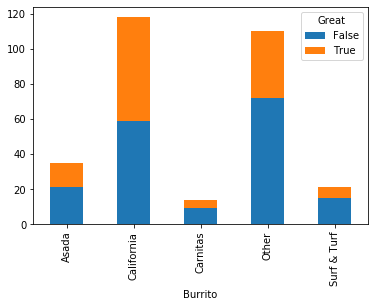



Tortilla  Great
1.40      False    1.000000
1.50      False    0.833333
          True     0.166667
2.00      False    0.857143
          True     0.142857
2.10      False    1.000000
2.50      False    1.000000
2.80      False    1.000000
3.00      False    0.680556
          True     0.319444
3.20      True     1.000000
3.50      False    0.777778
          True     0.222222
3.60      False    1.000000
3.75      False    1.000000
3.80      True     0.800000
          False    0.200000
4.00      True     0.619565
          False    0.380435
4.50      True     0.526316
          False    0.473684
4.80      True     1.000000
5.00      True     0.800000
          False    0.200000
Name: Great, dtype: float64 



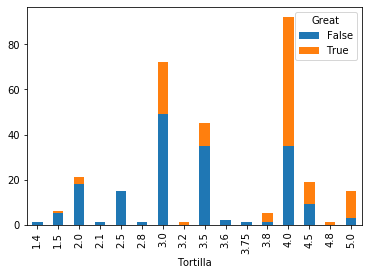



Synergy  Great
1.00     False    1.000000
1.50     False    1.000000
2.00     False    1.000000
2.30     False    1.000000
2.50     False    1.000000
2.70     False    1.000000
2.80     False    1.000000
2.90     False    1.000000
3.00     False    0.857143
         True     0.142857
3.30     False    1.000000
3.40     False    1.000000
3.50     False    0.750000
         True     0.250000
3.70     False    1.000000
3.75     False    1.000000
3.80     False    1.000000
4.00     True     0.592593
         False    0.407407
4.20     True     1.000000
4.30     True     1.000000
4.40     True     1.000000
4.50     True     0.848485
         False    0.151515
4.70     True     1.000000
4.90     True     1.000000
5.00     True     1.000000
Name: Great, dtype: float64 



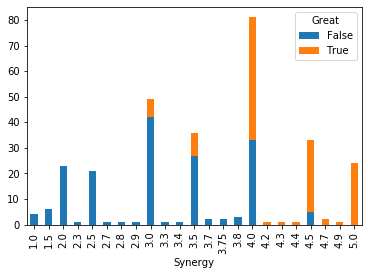



Uniformity  Great
1.0         False    0.916667
            True     0.083333
1.5         False    0.900000
            True     0.100000
1.6         False    1.000000
2.0         False    0.729730
            True     0.270270
2.2         True     1.000000
2.3         False    1.000000
2.4         False    1.000000
2.5         False    0.750000
            True     0.250000
2.7         False    1.000000
3.0         False    0.736842
            True     0.263158
3.2         False    1.000000
3.5         False    0.636364
            True     0.363636
4.0         True     0.550000
            False    0.450000
4.2         True     1.000000
4.3         False    1.000000
4.4         True     1.000000
4.5         True     0.566667
            False    0.433333
5.0         True     0.633333
            False    0.366667
Name: Great, dtype: float64 



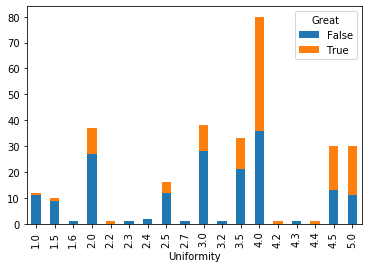



Hunger  Great
0.50    False    1.000000
1.00    False    0.666667
        True     0.333333
1.50    False    1.000000
2.00    False    0.619048
        True     0.380952
2.20    False    1.000000
2.30    False    1.000000
2.50    False    0.611111
        True     0.388889
2.80    True     1.000000
3.00    False    0.694915
        True     0.305085
3.20    False    1.000000
3.50    False    0.625000
        True     0.375000
3.70    False    0.500000
        True     0.500000
3.75    False    1.000000
3.80    True     1.000000
3.90    False    1.000000
4.00    False    0.529412
        True     0.470588
4.10    True     1.000000
4.25    False    1.000000
4.30    True     1.000000
4.50    True     0.562500
        False    0.437500
4.75    False    1.000000
5.00    True     0.625000
        False    0.375000
Name: Great, dtype: float64 



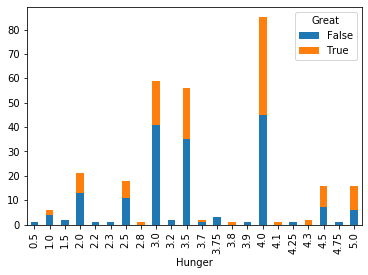



Wrap  Great
0.0   False    1.000000
0.5   False    1.000000
1.0   False    0.875000
      True     0.125000
1.2   False    1.000000
1.5   False    0.625000
      True     0.375000
2.0   False    0.583333
      True     0.416667
2.2   True     1.000000
2.5   False    0.800000
      True     0.200000
2.6   False    1.000000
3.0   False    0.600000
      True     0.400000
3.5   False    0.833333
      True     0.166667
3.8   True     1.000000
3.9   False    1.000000
4.0   False    0.500000
      True     0.500000
4.5   False    0.591837
      True     0.408163
5.0   False    0.551020
      True     0.448980
Name: Great, dtype: float64 



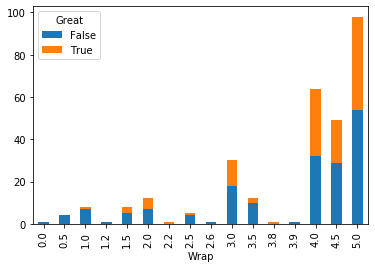



Fillings  Great
1.00      False    1.000000
1.50      False    1.000000
2.00      False    1.000000
2.40      False    1.000000
2.50      False    0.888889
          True     0.111111
2.75      False    1.000000
2.80      False    0.750000
          True     0.250000
3.00      False    0.878788
          True     0.121212
3.20      False    1.000000
3.30      False    1.000000
3.40      False    1.000000
3.50      False    0.666667
          True     0.333333
4.00      True     0.604938
          False    0.395062
4.20      True     1.000000
4.30      True     1.000000
4.40      True     1.000000
4.50      True     0.761905
          False    0.238095
4.70      False    0.500000
          True     0.500000
5.00      True     1.000000
Name: Great, dtype: float64 



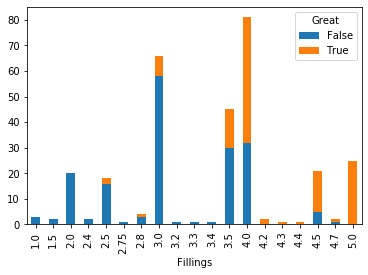



Cost   Great
2.99   True     1.0
3.50   False    1.0
3.75   False    1.0
3.99   False    1.0
4.59   True     1.0
               ... 
9.50   False    1.0
9.99   True     1.0
10.50  False    1.0
11.75  True     1.0
11.95  True     1.0
Name: Great, Length: 109, dtype: float64 



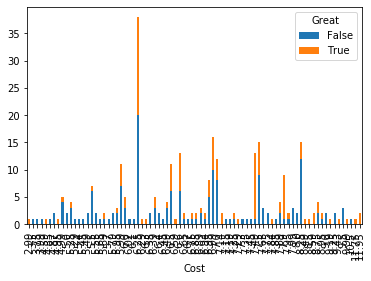



Meat:filling  Great
0.50          False    1.000000
1.00          False    0.888889
              True     0.111111
1.40          False    1.000000
1.50          False    1.000000
2.00          False    1.000000
2.50          False    0.888889
              True     0.111111
2.80          False    1.000000
2.90          False    1.000000
3.00          False    0.743590
              True     0.256410
3.20          True     1.000000
3.40          False    1.000000
3.50          False    0.593750
              True     0.406250
3.60          False    1.000000
3.70          False    1.000000
3.75          False    0.666667
              True     0.333333
3.78          True     1.000000
3.80          False    1.000000
4.00          True     0.518072
              False    0.481928
4.20          False    1.000000
4.50          True     0.633333
              False    0.366667
4.70          True     1.000000
4.80          False    1.000000
5.00          True     0.781250
              Fals

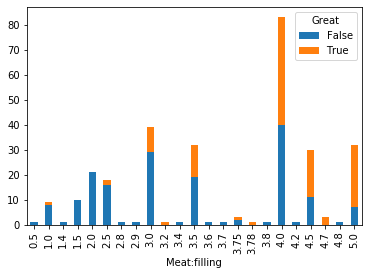



Meat  Great
1.00  False    1.000000
1.50  False    1.000000
2.00  False    1.000000
2.50  False    0.937500
      True     0.062500
2.60  False    1.000000
2.70  False    1.000000
2.75  False    1.000000
2.80  False    1.000000
3.00  False    0.901961
      True     0.098039
3.20  False    1.000000
3.30  False    1.000000
3.50  False    0.723404
      True     0.276596
3.70  False    1.000000
3.75  False    1.000000
3.80  False    1.000000
4.00  True     0.666667
      False    0.333333
4.20  True     1.000000
4.50  True     0.800000
      False    0.200000
4.70  True     1.000000
5.00  True     0.800000
      False    0.200000
Name: Great, dtype: float64 



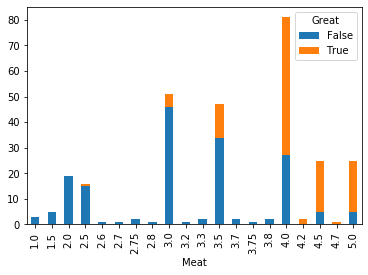



Temp  Great
1.0   False    1.000000
1.3   False    1.000000
1.5   False    1.000000
1.9   False    1.000000
2.0   False    0.550000
      True     0.450000
2.5   False    0.920000
      True     0.080000
3.0   False    0.850000
      True     0.150000
3.2   False    1.000000
3.5   False    0.600000
      True     0.400000
3.6   True     1.000000
3.7   False    1.000000
3.8   True     0.666667
      False    0.333333
4.0   False    0.500000
      True     0.500000
4.4   True     1.000000
4.5   False    0.514286
      True     0.485714
4.7   True     1.000000
5.0   True     0.568627
      False    0.431373
Name: Great, dtype: float64 



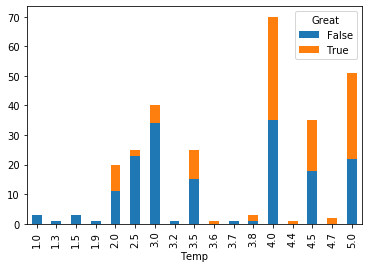



Salsa  Great
0.00   False    1.000000
0.50   False    1.000000
1.00   False    1.000000
1.50   False    1.000000
1.80   True     1.000000
2.00   False    0.827586
       True     0.172414
2.20   False    1.000000
2.50   False    0.777778
       True     0.222222
2.75   False    1.000000
3.00   False    0.706897
       True     0.293103
3.20   False    1.000000
3.50   False    0.666667
       True     0.333333
3.70   True     1.000000
3.75   False    1.000000
3.80   False    1.000000
4.00   True     0.553571
       False    0.446429
4.20   True     1.000000
4.30   True     1.000000
4.50   True     0.720000
       False    0.280000
4.75   True     1.000000
5.00   True     0.777778
       False    0.222222
Name: Great, dtype: float64 



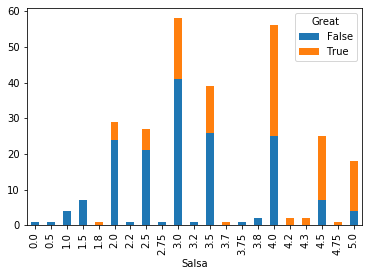



Length  Great
15.00   False    1.000000
15.50   True     1.000000
16.00   False    1.000000
16.50   False    0.600000
        True     0.400000
17.00   False    0.666667
        True     0.333333
17.50   False    0.571429
        True     0.428571
17.70   True     1.000000
17.78   False    1.000000
18.00   False    0.687500
        True     0.312500
18.50   False    0.625000
        True     0.375000
19.00   False    0.526316
        True     0.473684
19.50   False    0.846154
        True     0.153846
20.00   False    0.650000
        True     0.350000
20.50   False    0.692308
        True     0.307692
20.75   False    1.000000
21.00   False    0.625000
        True     0.375000
21.50   False    0.714286
        True     0.285714
22.00   True     0.700000
        False    0.300000
22.50   True     0.555556
        False    0.444444
23.00   True     0.666667
        False    0.333333
23.50   False    0.666667
        True     0.333333
24.00   False    1.000000
25.00   False    1.000

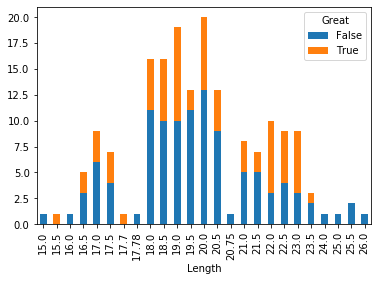



Circum  Great
17.000  False    1.000000
18.000  False    1.000000
18.500  False    1.000000
19.000  False    0.666667
        True     0.333333
19.500  False    0.750000
        True     0.250000
20.000  False    0.714286
        True     0.285714
20.500  False    0.846154
        True     0.153846
20.800  False    1.000000
21.000  True     0.526316
        False    0.473684
21.200  True     1.000000
21.500  False    0.588235
        True     0.411765
21.750  False    1.000000
22.000  False    0.517241
        True     0.482759
22.125  False    1.000000
22.225  False    1.000000
22.500  False    0.818182
        True     0.181818
22.750  True     1.000000
23.000  False    0.533333
        True     0.466667
23.500  True     0.600000
        False    0.400000
24.000  True     0.571429
        False    0.428571
24.500  False    1.000000
25.000  False    0.500000
        True     0.500000
25.500  False    1.000000
26.000  True     1.000000
26.500  False    1.000000
27.000  False    1.000

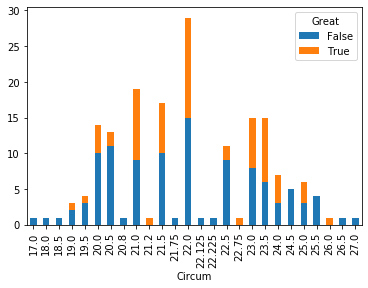



Volume  Great
0.40    False    1.0
0.50    False    1.0
0.51    False    1.0
0.54    False    0.5
        True     0.5
                ... 
1.05    True     1.0
1.07    False    1.0
1.16    False    1.0
1.17    False    1.0
1.24    False    1.0
Name: Great, Length: 78, dtype: float64 



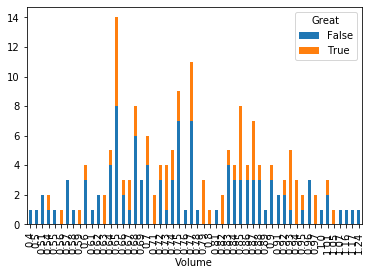

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

features = ['Burrito','Tortilla','Synergy','Uniformity', 
        'Hunger','Wrap','Fillings','Cost','Meat:filling', 
        'Meat','Temp','Salsa','Length','Circum','Volume']

for feature in features:

  #Looking at features against target
  compare = train.groupby(feature)['Great'].value_counts(normalize=True)
  print(compare, '\n')

  #Creating graph to visualize how categorical data against functional target
  train.groupby(feature)['Great'].value_counts().unstack().plot(kind='bar', stacked=True);
  plt.xticks(rotation=90);
  plt.show();

  print('\n')

In [28]:
train.corr()

,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,Year
Yelp,1.000000,0.585133,0.013569,0.109067,0.397478,0.065553,0.325606,0.274195,-0.000352,0.078049,0.286679,0.005976,-0.072920,0.189677,0.272944,-0.059679,0.205121,NaN
Google,0.585133,1.000000,-0.001470,0.138669,0.160693,0.151752,0.223473,0.326674,-0.094125,0.058849,0.332585,0.154295,-0.054090,0.265229,0.269943,-0.024867,0.159915,NaN
Cost,0.013569,-0.001470,1.000000,0.002414,-0.079064,0.403674,0.302008,-0.049891,-0.083887,0.168506,0.185456,-0.076590,-0.106477,0.150133,0.050917,-0.163589,0.142365,-0.053477
Hunger,0.109067,0.138669,0.002414,1.000000,0.118518,-0.158323,-0.073466,0.146126,0.087378,0.081790,0.183629,0.121039,0.094913,0.133990,0.168491,0.012002,0.158043,-0.044626
Length,0.397478,0.160693,-0.079064,0.118518,1.000000,-0.067762,0.527826,0.165723,-0.067528,-0.054290,0.109499,-0.038337,0.045785,0.041607,0.071656,0.040159,0.045870,NaN
Circum,0.065553,0.151752,0.403674,-0.158323,-0.067762,1.000000,0.806687,0.048642,-0.186784,0.158569,0.124948,-0.028323,-0.029974,0.102384,0.068080,-0.175470,0.067621,NaN
Volume,0.325606,0.223473,0.302008,-0.073466,0.527826,0.806687,1.000000,0.135366,-0.195904,0.101055,0.167131,-0.053833,-0.002003,0.097130,0.091221,-0.135104,0.072906,NaN
Tortilla,0.274195,0.326674,-0.049891,0.146126,0.165723,0.048642,0.135366,1.000000,0.287502,0.282051,0.375572,0.244356,0.245504,0.280748,0.353218,0.164170,0.377766,0.011925
Temp,-0.000352,-0.094125,-0.083887,0.087378,-0.067528,-0.186784,-0.195904,0.287502,1.000000,0.246524,0.199128,0.173743,0.163125,0.116437,0.215297,0.152208,0.290867,NaN
Meat,0.078049,0.058849,0.168506,0.081790,-0.054290,0.158569,0.101055,0.282051,0.246524,1.000000,0.591808,0.388833,0.255857,0.376505,0.615289,0.065596,0.572249,0.084178


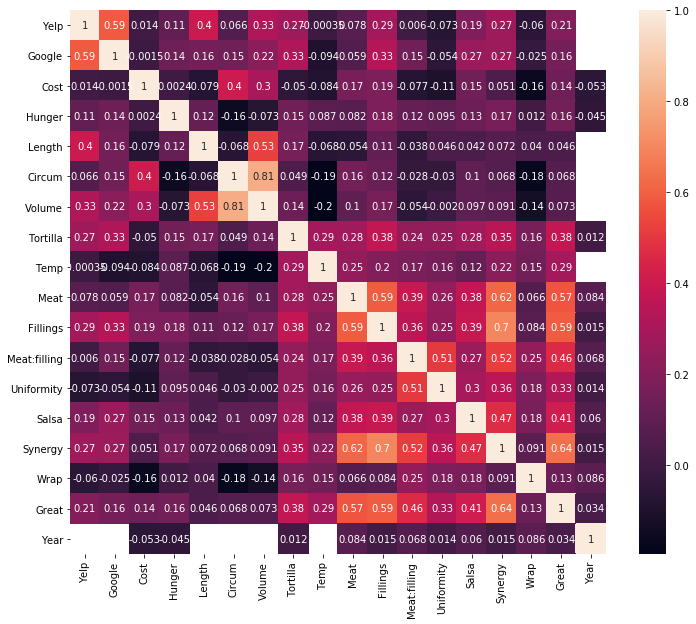

In [29]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(data = train.corr(), annot=True)

#https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show();

## Creating Function to Apply Feature Engineering

In [30]:
def engineer_features(X):
    #Avoid SettingWithCopyWarning
    X = X.copy()
    
    #Replace x's with 1 and NaNs with 0
    #Making an assumption that NaNs for the fillings are 0 and 
    #that the x's are meant to meant that these items were included. 
    cols = ['Salsa', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream']
    X[cols] = X[cols].fillna(0)
    X[cols] = X[cols].replace('x', '1')
    
    #Replace Yelp and Google reviews with averages 
    X = X.drop(columns = ['Yelp', 'Google', 'Year'])
    
    #Replacing Circumference, Volume, and Length with the averages basead on the type of Burrito
    X['Circum'] = X.groupby('Burrito')['Circum'].transform(lambda x: x.fillna(x.mean()))
    X['Volume'] = X.groupby('Burrito')['Volume'].transform(lambda x: x.fillna(x.mean()))
    X['Length'] = X.groupby('Burrito')['Length'].transform(lambda x: x.fillna(x.mean()))
    
    #Return the dataframe
    return X

train = engineer_features(train)
val = engineer_features(val)
test = engineer_features(test)

In [31]:
print(train.shape)
train.head(10)

(298, 23)


,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,...,Salsa,Synergy,Wrap,Beef,Pico,Guac,Cheese,Fries,Sour cream,Great
0,California,2016-01-18,6.49,3.0,19.969737,22.242434,0.786842,3.0,5.0,3.0,...,4.0,4.0,4.0,1,1,1,1,1,0,False
1,California,2016-01-24,5.45,3.5,19.969737,22.242434,0.786842,2.0,3.5,2.5,...,3.5,2.5,5.0,1,1,1,1,1,0,False
2,Carnitas,2016-01-24,4.85,1.5,19.000000,21.500000,0.701250,3.0,2.0,2.5,...,3.0,3.0,5.0,0,1,1,0,0,0,False
3,Asada,2016-01-24,5.25,2.0,19.717391,21.113636,0.708182,3.0,2.0,3.5,...,4.0,4.0,5.0,1,1,1,0,0,0,False
4,California,2016-01-27,6.59,4.0,19.969737,22.242434,0.786842,4.0,5.0,4.0,...,2.5,4.5,4.0,1,1,0,1,1,0,True
5,Other,2016-01-28,6.99,4.0,19.777321,21.922768,0.762679,3.0,4.0,5.0,...,2.5,4.0,1.0,0,0,1,1,0,1,False
6,California,2016-01-30,7.19,1.5,19.969737,22.242434,0.786842,2.0,3.0,3.0,...,0.0,2.0,3.0,1,0,0,1,1,1,False
7,Carnitas,2016-01-30,6.99,4.0,19.000000,21.500000,0.701250,2.5,3.0,3.0,...,0.0,2.5,3.0,0,1,1,0,0,0,False
8,California,2016-02-01,9.25,3.5,19.969737,22.242434,0.786842,2.0,4.5,4.5,...,3.5,4.0,2.0,1,1,1,1,1,1,False
9,Asada,2016-02-06,6.25,3.5,19.717391,21.113636,0.708182,2.5,1.5,1.5,...,1.5,2.0,4.5,1,1,1,0,0,0,False


In [32]:
train.isnull().sum()

Burrito          0
Date             0
Cost             6
Hunger           1
Length           0
Circum           0
Volume           0
Tortilla         0
Temp            15
Meat            10
Fillings         1
Meat:filling     6
Uniformity       2
Salsa            0
Synergy          2
Wrap             2
Beef             0
Pico             0
Guac             0
Cheese           0
Fries            0
Sour cream       0
Great            0
dtype: int64

## Use scikit-learn for logistic regression.

In [33]:
target = 'Great'
features = ['Tortilla', 'Temp', 'Meat', 'Fillings',
            'Salsa', 'Synergy', 'Wrap', 'Cost', 'Meat:filling']

In [34]:
#1 Import the estimator class
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#2 Instantiate the class
log_reg = LogisticRegression(random_state=42)

#3 Arrange X feautre matrices and y target vectors
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

# OneHotEncoding
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Imputing missing values
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

#4 Fit the model
log_reg.fit(X_train_scaled, y_train)


/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [35]:
#5 Apply the model to new data.
y_pred = log_reg.predict(X_val_scaled)
print('Validation Accuracy', accuracy_score(y_pred, y_val))
print('Validation Accuracy', log_reg.score(X_val_scaled, y_val))

Validation Accuracy 0.8352941176470589
Validation Accuracy 0.8352941176470589


**Plot coefficients**

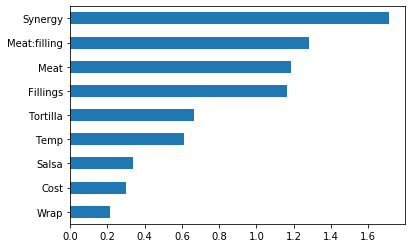

In [36]:
coefficients = pd.Series(log_reg.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

## Get your model's test accuracy. (One time, at the end.)

In [37]:
X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)

In [39]:
y_test = test[target]

In [40]:
y_pred_test = log_reg.predict(X_test_scaled)
print('Validation Accuracy', accuracy_score(y_pred_test, y_test))
print('Validation Accuracy', log_reg.score(X_test_scaled, y_test))

Validation Accuracy 0.7631578947368421
Validation Accuracy 0.7631578947368421


## Scikit-learn Pipeline

In [42]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LogisticRegression()
)

#Fit on train
pipeline.fit(X_train, y_train)

#Score on train/val
print('Training Accuracy', pipeline.score(X_train, y_train))

#Predict on Test Data
y_pred = pipeline.predict(X_test)
print('Testing Accuracy', pipeline.score(X_test, y_test))

Training Accuracy 0.8322147651006712
Testing Accuracy 0.7105263157894737


/Users/jisha/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Kaggle Submission

In [43]:
submission = test[['Burrito']].copy()
submission

,Burrito
77,California
386,California
387,Other
388,California
389,Other
390,Asada
391,Carnitas
392,Carnitas
393,Carnitas
394,California


In [44]:
submission['Great'] = y_pred_test
submission

,Burrito,Great
77,California,True
386,California,True
387,Other,False
388,California,True
389,Other,False
390,Asada,False
391,Carnitas,True
392,Carnitas,True
393,Carnitas,True
394,California,True


In [45]:
submission.to_csv('my_submission.csv', index = False)